# Week 1 Project

**Students**: Sergio Casas Pastor, Sanket Biswas and Josep Brugués i Pujolràs

**TEST CODE**

In [7]:
import cv2
import numpy as np
import cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import time
from matplotlib import pyplot as plt

Let us first read the train and test files

In [8]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','r'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','r'))
train_labels = cPickle.load(open('train_labels.dat','r'))
test_labels = cPickle.load(open('test_labels.dat','r'))

In [9]:
train_images_filenames[12]

'../../Databases/MIT_split/train/Opencountry/fie26.jpg'

We create a SIFT object detector and descriptor

In [10]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=900)
start = time.time()

We compute different spatial pyramid level

In [11]:
level = 4

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [12]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    step = 10 # Separation of 10 pixels between keypoints
    descriptors = []
    
    # Compute spatial pyramids
    height_block = int(np.ceil(ima.shape[0] / level))  # Number of height pixels for sub-image
    width_block = int(np.ceil(ima.shape[1] / level))    # Number of width pixels for sub-image
    
    for i in range(0, ima.shape[0], height_block):
        for j in range(0, ima.shape[1], width_block):
            block = gray[i:i + height_block, j:j + width_block]
            keypoints_block = []
            for k in range(step/2, block.shape[0], step):
                for l in range(step/2, block.shape[1], step):             
                    keypoints_block.append(cv2.KeyPoint(k, l, step))
                    
            _, descriptors_block = SIFTdetector.compute(block,keypoints_block)
            descriptors.extend(descriptors_block)
    
    Train_descriptors.append(descriptors)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

We now compute a k-means clustering on the descriptor space

In [13]:
k = 170
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=3400, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=170, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [14]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in xrange(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors

In [15]:
knn = KNeighborsClassifier(n_neighbors=20,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, Train_label_per_descriptor) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
           weights='uniform')

We end up computing the test descriptors and compute the accuracy of the model

In [16]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for image in range(len(test_images_filenames)):
    filename=test_images_filenames[image]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    descriptors = []
    
    # Compute spatial pyramids
    height_block = int(np.ceil(ima.shape[0] / level))  # Number of height pixels for sub-image
    width_block = int(np.ceil(ima.shape[1] / level))    # Number of width pixels for sub-image
    for i in range(0, ima.shape[0], height_block):
        for j in range(0, ima.shape[1], width_block):
            block = gray[i:i + height_block, j:j + width_block]
            keypoints_block = []

            for m in range(step/2, block.shape[0], step):
                for n in range(step/2, block.shape[1], step):             
                    keypoints_block.append(cv2.KeyPoint(m, n, step))
            
            _, descriptors_block = SIFTdetector.compute(block, keypoints_block)
            descriptors.extend(descriptors_block)
    
    words=codebook.predict(descriptors)
    visual_words_test[image,:]=np.bincount(words,minlength=k)    

In [17]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)
end = time.time()
print(end - start)

71.87112763320943
133.729643822


Dimensionality reduction, with PCA and LDA

In [18]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=20,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

72.11895910780669


In [19]:
lda = LinearDiscriminantAnalysis(n_components=64)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=20,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

/home/josep/Documents/Python/venv27/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


75.34076827757124


**RESULTS AND DISCUSSION**

We test different amount of local features.
We keep the rest of the parameters with initial values (SIFT, Codebook size k = 128, neighbours k = 5, euclidean distance, no reduction)

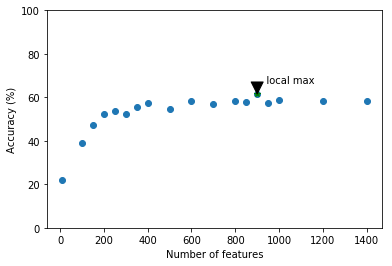

In [20]:
number = [10, 100, 150, 200, 250, 300, 350, 400, 500, 600, 700, 800, 850, 900, 950, 1000, 1200, 1400]
accuracy = [22.18, 39.03, 47.21, 52.42, 53.53, 52.42, 55.64, 57.5, 54.77, 58.24, 56.88, 58.11, 57.74, 61.34, 57.49, 58.99, 58.36, 58.49]
plt.scatter(number, accuracy)
plt.plot(number[13], accuracy[13], 'g*')
plt.ylim((0, 100))
plt.xlabel("Number of features")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = number[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()

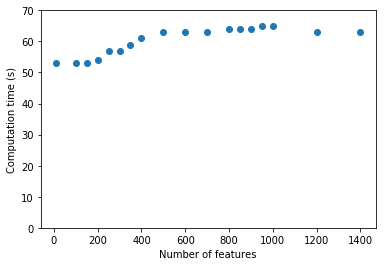

In [21]:
time = [53, 53, 53, 54, 57, 57, 59, 61, 63, 63, 63, 64, 64, 64, 65, 65, 63, 63]
plt.scatter(number, time)
plt.ylim((0, 70))
plt.xlabel("Number of features")
plt.ylabel("Computation time (s)")
plt.show()

We get the maximum accuracy with 900 features. The computation time is very similar using different number of features. Therefore, we conclude that, using SIFT feature detector, Codebook size 128, 5 k-nn neighbours, euclidean distance and no reduction, the best performance is with approximate 900 features.

We now use dense SIFT instead of detected keypoints. This way, the detected keypoints are equally distributed in the image and not only in the interesting points. There is a parameter (step size) we can vary to create different distributions. We again keep the rest of the parameters like before.

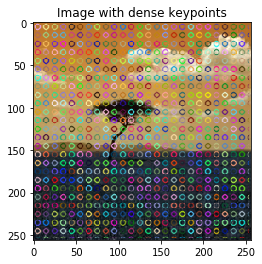

Example of dense SIFT


In [22]:
filename=train_images_filenames[1]
ima=cv2.imread(filename)
gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
step = 10
kpt = []
    
for i in xrange(step/2, ima.shape[0], step):
    for j in xrange(step/2, ima.shape[1], step):
        kpt.append(cv2.KeyPoint(i, j, step))
     
kpt,des=SIFTdetector.compute(gray,kpt)

keypointsIma = ima
keypointsIma = cv2.drawKeypoints(ima, kpt, keypointsIma)
plt.imshow(keypointsIma)
plt.title('Image with dense keypoints')
plt.show()
print("Example of dense SIFT")

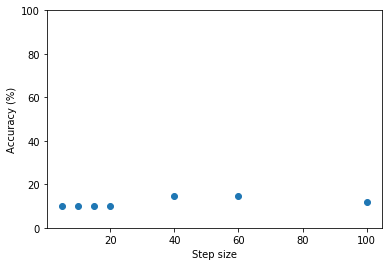

In [23]:
step = [5, 10, 15, 20, 40, 60, 100]
accuracy = [9.91, 9.91, 9.91, 9.91, 14.62, 14.62, 11.64]
plt.scatter(step, accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("Accuracy (%)")
plt.show()

Dense SIFT keypoint detector produces much worse results than normal SIFT keypoint detector because the keypoints are not only in the interesting regions.

Now using the best number of features found, and without using dense SIFT, we then find which is the best number of codewords for the k-means. We first iterate over the powers of 2. Once the best two values were found, we precise the k parameter a little bit more just to get the best result possible.

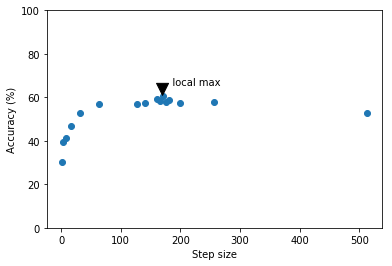

Local max is 60.71 % accuracy at k= 170


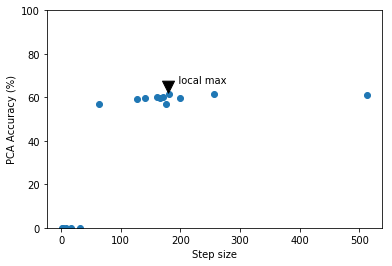

Local max is 61.71 % PCA accuracy at k= 180


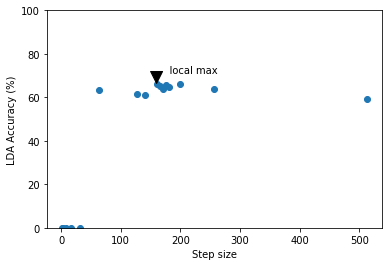

Local max is 66.17 % LDA accuracy at k= 160


In [24]:
k = [2,4,8,16,32,64,128,140,160,165,170,175,180,200,256,512]
accuracy = [30.23,39.28,41.14,46.71,52.91,56.75,56.87,57.62,59.1,58.48,60.71,57.74,58.98, 57.24,57.74,52.91]
pca_accuracy = [0,0,0,0,0,56.75,59.23,59.47,60.22,59.72,60.09,57.12,61.71,59.6,61.58,61.09]
lda_accuracy = [0,0,0,0,0,63.19,61.71,61.21,66.17,65.03,63.94,65.67,64.93,65.92,63.81,59.1]

plt.scatter(k, accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% accuracy at k=",xmax

plt.scatter(k, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% PCA accuracy at k=",xmax


plt.scatter(k, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

plt.show()
print "Local max is", ymax,"% LDA accuracy at k=",xmax


Overall, we think that k=170 is the best option since it gets the best accuracy without applying any feature reduction algorithm. If we look at the computational time, there is almost no overhead added with different changes in the K value (if we take into account that a slower processor than before has been used). 

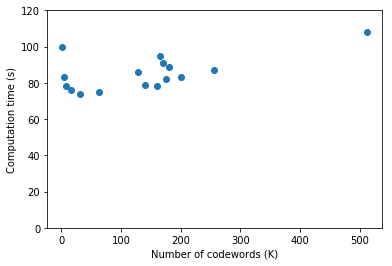

In [25]:
k = [2,4,8,16,32,64,128,140,160,165,170,175,180,200,256,512]
time = [100,83,78,76,74,75,86,79,78,95,91,82,89,83,87,108]
plt.scatter(k, time)
plt.ylim((0, 120))
plt.xlabel("Number of codewords (K)")
plt.ylabel("Computation time (s)")
plt.show()

Once the best number of codewords was established, we look to optimize the number of neighbours taken into account by the K-NN classifier. We use the best number of features (900) and the best number of codewords (170), leaving the rest of parameters as default. 

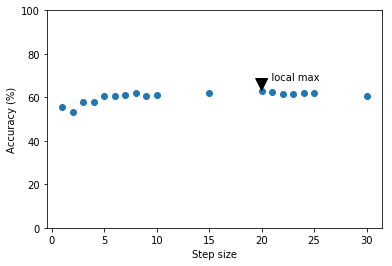

Local max is 62.94 % accuracy at k= 20


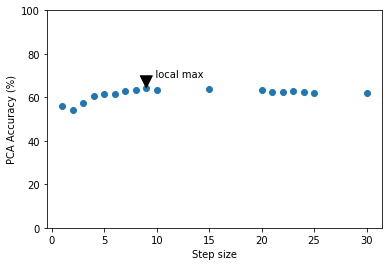

Local max is 64.18 % PCA accuracy at k= 9


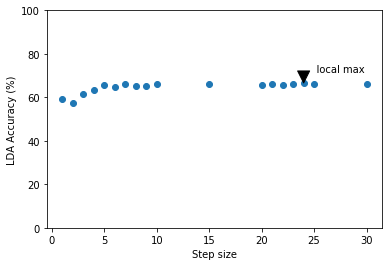

Local max is 66.41 % LDA accuracy at k= 24


In [26]:
k = [1,2,3,4,5,6,7,8,9,10,15,20,21,22,23,24,25,30]
accuracy = [55.63,53.4,57.99,57.86,60.71,60.47,60.96,61.83,60.71,60.96,62.08,62.94,62.57,61.46,61.46,61.95,62.20,60.47]
pca_accuracy = [56.01,54.27,57.62,60.71,61.33,61.71,62.94,63.19,64.18,63.32,63.81,63.32,62.45,62.57,62.70,62.57,62.08,62.20]
lda_accuracy = [59.1,57.62,61.71,63.56,65.67,64.68,66.17,65.42,65.17,66.17,66.29,65.79,65.92,65.79,66.17,66.41,66.17,66.04]

plt.scatter(k, accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% accuracy at k=",xmax

plt.scatter(k, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% PCA accuracy at k=",xmax


plt.scatter(k, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

plt.show()
print "Local max is", ymax,"% LDA accuracy at k=",xmax

From the results just presented, we think that looking at k=20 neighbours is the best option, since it has the best accuracy without reducing the number of features and, when reducing features, it does not lose much accuracy with respect to the best PCA and LDA results. Despite that, the improvement is not big, taking into account the results obtained before when analysing the number of features and the number of codewords.

After that, we test different distances for the k-NN algorithm, to see which one was the best suited.

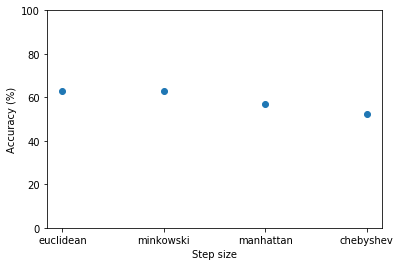

Local max is 62.94 % accuracy


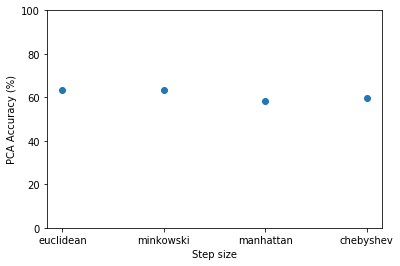

Local max is 63.32 % PCA accuracy


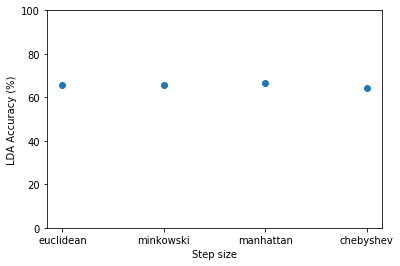

Local max is 66.54 % LDA accuracy


In [27]:
distances = ["euclidean","minkowski", "manhattan", "chebyshev"]
accuracy = [62.94,62.94,56.75,52.29]
pca_accuracy = [63.32,63.32,58.36,59.85]
lda_accuracy = [65.79,65.79,66.54,64.31]

plt.scatter(distances, accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = k[xpos]
plt.show()
print "Local max is", ymax,"% accuracy"

plt.scatter(distances, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = k[xpos]
plt.show()
print "Local max is", ymax,"% PCA accuracy"


plt.scatter(distances, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = k[xpos]
plt.show()
print "Local max is", ymax,"% LDA accuracy"

As we can see from the plots above, the best performing distance is the euclidean (when not performing any kind of feature reduction). That means that using other distances does not make any difference. 
Minkowski distance is the generalization of the rest of the distances. It contains a parameter p. When p = 1, minkowski distance is manhattan; when p = 2, minkowski distance is euclidean; and when p = infinity, minkowski distance is chebyshev.

Representation of some points using different distances


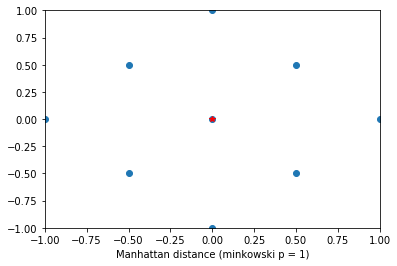

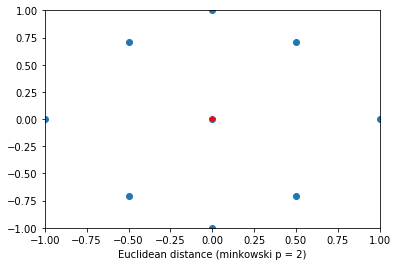

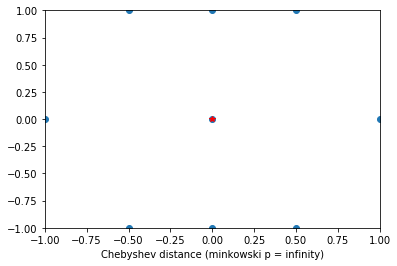

In [28]:
print "Representation of some points using different distances"
x = [0, 1, 0.5, 0, -0.5, -1, -0.5, 0, 0.5]
manhattan = [0, 0, 0.5, 1, 0.5, 0, -0.5, -1, -0.5]
euclidean = [0, 0, 0.71, 1, 0.71, 0, -0.71, -1, -0.71]
chebyshev = [0, 0, 1, 1, 1, 0, -1, -1, -1]

plt.scatter(x, manhattan)
plt.ylim((-1, 1))
plt.xlim((-1, 1))
plt.xlabel("Manhattan distance (minkowski p = 1)")
plt.plot(x[0], manhattan[0], 'r*')
plt.show()


plt.scatter(x, euclidean)
plt.ylim((-1, 1))
plt.xlim((-1, 1))
plt.xlabel("Euclidean distance (minkowski p = 2)")
plt.plot(x[0], manhattan[0], 'r*')
plt.show()

plt.scatter(x, chebyshev)
plt.ylim((-1, 1))
plt.xlim((-1, 1))
plt.xlabel("Chebyshev distance (minkowski p = infinity)")
plt.plot(x[0], chebyshev[0], 'r*')
plt.show()

In our test, we use minkowski p = 2, so it is the same as euclidean distance. That is why minkowski distance accuracy is the same as euclidean distance. 

The reason why euclidean distance is the best is because the distance in all directions is the same.

**Conclusions**

Dimensionality reduction actually has helped to improve the classification accuracy as shown in our experiments. PCA and LDA for reducing dimensionality of computed features has helped to increase accuracy in most cases. This is because it takes the most important features into the global feature representation vector before finally classifying the features with the K-Nearest Neighbours algorithm with the different distance metrics applied. The redundant features are taken out and hence this optimizes the computation time as well as improvises the model accuracy for classification.  

Comparing between LDA and PCA, LDA with k-Nearest Neighbors classifier gives us better results than PCA because it also takes the class labels, unlike PCA, helps to calculate the max separation between mean of the projected classes and chooses the dimension with minimum variance among them. The discriminatory information mostly lies in the mean and hence we get more improved results than PCA as shown in the visualizations of results and experiments.       

Finally, the classification task may be improved by experimenting with classifier algorihms like Support Vector Machines or Random Forests, in place of K-Nearest Neighbours which we used in this experiment.